In [112]:
import numpy as np
from scipy.integrate import solve_ivp
from SALib.sample import saltelli, sobol, fast_sampler
from SALib.analyze import sobol, fast
import seaborn as sns
import SALib
import matplotlib.pyplot as plt
import math
from scipy.optimize import fsolve
from scipy.constants import N_A

In [113]:
#Constants

Target_cell_number = 2e5
E_T_ratio = 1
well_size = 150e-6
sigma = well_size*N_A/Target_cell_number
synapse_gap = 25e-9
synapse_width = 10e-6
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
tumour_cell_IS_proportion = (synapse_width**2)/(tumour_cell_surface_area)
NK_cell_radius = 3.25e-6
NK_cell_surface_area = 4*math.pi*((NK_cell_radius)**2)
NK_cell_IS_proportion = (synapse_width**2)/NK_cell_surface_area
assay_to_synapse_conversion = (synapse_width**2*synapse_gap)/well_size
sigma_synapse = sigma*assay_to_synapse_conversion
synapse_area = synapse_width**2

In [114]:
def A1_steady_state(x, Atot, k1, koff, k2, rtot):
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

#Effector cell opsonization

def effector_A1(ftot, Atot, Q_D):

    a = 1
    b = -(ftot + Atot + Q_D)
    c = ftot*Atot
    if (b**2 - 4*a*c) <0:
        print(ftot, Atot/sigma, Q_D)
    
    return (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

def effector_A1_1(ftot, Atot, Q_D):

    a = 1
    b = -(ftot + Atot + Q_D)
    c = ftot*Atot
    #if (b**2 - 4*a*c) <0:
     #   print(ftot, Atot, Q_D)
    return (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

def EC50_finder(array, A0s):
    half_max = 0.5*np.max(array) 
    half_max_array = half_max*np.ones_like(array)
    indicies = np.argwhere(np.diff(np.sign(half_max_array-array)))
    return A0s[indicies[0]]

In [115]:
def A1_steady_state(x, Atot, k1, koff, k2, rtot):
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

#Effector cell opsonization

def effector_A1(ftot, Atot, Q_D):

    a = 1
    b = -(ftot + Atot + Q_D)
    c = ftot*Atot

    return (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

def S_two_cells(t, z, k1, k2, k3, k4, k5, k6, k7, k1off, k2off, rtot_synapse, ftot_synapse, Atot):


    A0 = (Atot - (z[0] + z[1] + z[3] + z[4] + z[2]))
    rt = rtot_synapse- z[0] - z[3] - 2*(z[1] + z[4])
    rf = ftot_synapse - z[2] - (z[3] + z[4])
    
    dA10 =   2*k1*(A0)*(rt) - k1off*z[0] - k2*1*z[0]*(rt) + 2*k1off*z[1] - k4*z[0]*(rf) + k2off*z[3]
    dA20 = k2*1*z[0]*(rt) - 2*k1off*z[1] - k5*z[1]*(rf) + k2off*z[4]
    dA01 =  k3*(A0)*(rf) - k2off*z[2] - 2*1*k6*z[2]*(rt) + k1off*z[3]
    dA11 = k4*z[0]*(rf) - k2off*z[3] + 2*1*k6*z[2]*(rt) - k1off*z[3] - 1*k7*z[3]*(rt) + 2*1*k1off*z[4]
    dA21 = k5*z[1]*(rf) - k2off*z[4] + 1*k7*z[3]*(rt) - 2*k1off*1*z[4]
    
    dz = [dA10, dA20, dA01, dA11, dA21]
    return np.asarray(dz, dtype="object")

In [116]:
def calc_crosslinks(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot):

    k2 = 4*D_t/tumour_cell_surface_area
    k1 = kon/sigma
    q1 = qon/sigma
    Q_D = qoff/q1
    k6 = 2*(D_t +D_f)/(synapse_area)  
    k7 = 2*D_t/synapse_area
    q1_bar = 2*(D_t+D_f)/synapse_area
    Q_D_bar = qoff/q1_bar
    Atot = Ainit*sigma
    
    A1_st_sin = fsolve(A1_steady_state, [1e-3], args=(Atot, k1, koff, k2, rtot))
    A2_st_sin = A2_steady_state(A1_st_sin, k2, koff, rtot)

    Atot = Atot - A1_st_sin - A2_st_sin
    Atot = Atot/E_T_ratio
    A1_E_stst = effector_A1(ftot, Atot, Q_D)
    if A1_E_stst <0:
        print(ftot, Atot)
    rtot_synapse = rtot*tumour_cell_IS_proportion
    A1_pre_synapse = A1_st_sin*tumour_cell_IS_proportion
    A2_pre_synapse = A2_st_sin*tumour_cell_IS_proportion
    A1_E_pre_synapse = A1_E_stst*NK_cell_IS_proportion
    ftot_synapse = ftot*NK_cell_IS_proportion
    A11_approx = 0
    A21_approx = 0
    fc_crosslinks = 0
    A10_approx = 0
    A20_approx = 0
    A01_approx = 0
    sol_guess = 0

    ftot_bar = ftot_synapse - A1_E_pre_synapse
    Atot_bar = A1_pre_synapse + A2_pre_synapse
    A1_synapse = effector_A1(ftot_bar, Atot_bar, Q_D_bar)
    A11_prop = A1_pre_synapse/(A1_pre_synapse + A2_pre_synapse)
    A21_prop = A2_pre_synapse/(A1_pre_synapse + A2_pre_synapse)
    A11_approx += A11_prop*A1_synapse
    A21_approx += A1_synapse*A21_prop
    A10_approx += (A1_pre_synapse - A11_approx)
    A20_approx += (A2_pre_synapse - A21_approx)
    sol_guess += A11_approx + 2*A21_approx
    A01_approx += A1_E_pre_synapse
    fc_crosslinks += A1_synapse

    rtot_bar = rtot_synapse - A1_pre_synapse - 2*A2_pre_synapse
    Atot_bar = A1_E_pre_synapse
    k1_bar = 2*(D_t + D_f)/synapse_area
    k2_bar = 2*D_t/synapse_area
    A1_st = fsolve(A1_steady_state, [1e-4], args=(Atot_bar, k1_bar, koff, k2_bar, rtot_bar))
    A2_st = A2_steady_state(A1_st, k2_bar, koff, rtot_bar)
    A11_approx += A1_st
    A21_approx += A2_st
    if A1_E_pre_synapse - A1_st -  A2_st <0:
        print(A1_E_pre_synapse, A1_st, A2_st)
    A01_approx +- A1_st + A2_st
    fc_crosslinks += (A1_st + A2_st)
    sol_guess += A1_st + 2*A2_st

    A1_E_stst = effector_A1_1(A01_approx , A01_approx , Q_D_bar)
    A1_st1 = fsolve(A1_steady_state, [1e-2], args=((fc_crosslinks + A1_E_stst) , k6, koff, k7, sol_guess))
    A2_st1 = A2_steady_state(A1_st1, k7, koff, sol_guess)
    correction = np.min([A1_E_stst - (A1_st1 + A2_st1 - fc_crosslinks) , A20_approx])

    crosslinks = A1_st1 + A2_st1 + correction

    return crosslinks


In [117]:
problem = {
    'num_vars': 9,
    'names': ['kon', 'koff', 'D_t', 'rtot', 'qon', 'qoff', 'D_f', 'ftot', 'dummy'],
    'bounds': [[4, 6],
               [-6, -4],
               [-15, -13],
               [4, 6],
               [3, 5],
               [-5, -3],
               [-15, -14],
               [4, 6],
               [1, 1000]]
}
problem1 = {
    'num_vars': 8,
    'names': ['kon', 'koff', 'D_t', 'qon', 'qoff', 'D_f', 'ftot', 'dummy'],
    'bounds': [[4, 6],
               [-6, -4],
               [-15, -13],
               [3, 5],
               [-5, -3],
               [-15, -14],
               [4, 6],
               [1, 1000]]
}

vals = SALib.sample.sobol.sample(problem, 128)
A0s = np.geomspace(1e-13, 1e-5, 65)
Y = np.zeros(len(vals))
Y1 = np.zeros(len(vals))
Y2 = np.zeros(len(vals))
indicies = []
t_end = 60*60*15
t = np.geomspace(1e-10, t_end, 60)
tspan = [1e-10, t_end]
print(len(vals))

2560


In [118]:
def calc_crosslinks_odes(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot):
    
    k2 = 4*D_t/tumour_cell_surface_area
    k1 = kon/sigma
    q1 = qon/sigma
    Q_D = qoff/q1

    k6 = 2*(D_t +D_f)/(synapse_area)  
    k7 = 2*D_t/synapse_area


    Atot = Ainit*sigma
    
    A1_st_sin = fsolve(A1_steady_state, [1e-2], args=(Atot, k1, koff, k2, rtot))
    A2_st_sin = A2_steady_state(A1_st_sin, k2, koff, rtot)
    
        
    Atot = Atot - A1_st_sin - A2_st_sin
    Atot = Atot/E_T_ratio
    A1_E_stst = effector_A1(ftot, Atot, Q_D)
        
    A1_pre_synapse = A1_st_sin*tumour_cell_IS_proportion
    A2_pre_synapse = A2_st_sin*tumour_cell_IS_proportion
    A1_E_pre_synapse = A1_E_stst*NK_cell_IS_proportion
    rtot_synapse = rtot*tumour_cell_IS_proportion
    ftot_synapse = ftot*NK_cell_IS_proportion
    Atot = A1_pre_synapse + A2_pre_synapse + A1_E_pre_synapse
    z_0 = np.asarray([A1_pre_synapse, A2_pre_synapse, A1_E_pre_synapse, 0, 0], dtype='object')
    k1 = kon/sigma_synapse
    k3 = qon/sigma_synapse
    k2 = 4*D_t/(synapse_area)
    k4 = 2*(D_t +D_f)/(synapse_area)   
    k5 = 2*(D_t +D_f)/(synapse_area)
    k6 = 2*(D_t +D_f)/(synapse_area)  
    k7 = 2*D_t/synapse_area
    z = solve_ivp(S_two_cells, tspan, z_0, method='BDF', atol=1e-5, rtol=1e-5,  t_eval=t, args=np.asarray([k1, k2, k3, k4, k5, k6, k7, koff, qoff, rtot_synapse, ftot_synapse, Atot], dtype='object'))
    A11 = z.y[3]
    A21 = z.y[4]
  

    crosslinks = A11[-1] + A21[-1]
    
    
    return crosslinks

In [119]:
for i, params in enumerate(vals):
    print(i)
    kon = params[0]
    kon = 10**kon
    koff = params[1]
    koff = 10**koff
    D_t = params[2]
    D_t = 10**D_t
    rtot = params[3]
    rtot = 10**rtot
    qon = params[4]
    qon = 10**qon
    qoff = params[5]
    qoff = 10**qoff
    D_f = params[6]
    D_f = 10**D_f
    ftot = params[7]
    ftot = 10**ftot
    dummy = params[8]
    
    holder = np.zeros_like(A0s)
    
    for j, Ainit in enumerate(A0s):

        holder[j] = calc_crosslinks_odes(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot)

    Y[i] = EC50_finder(holder, A0s)
    
Si = sobol.analyze(problem, Y, print_to_console=True)

0
1
2
3
4
5
6
7
8
9
10
11
12


KeyboardInterrupt: 

Text(0, 0.5, 'total order sobol indicies')

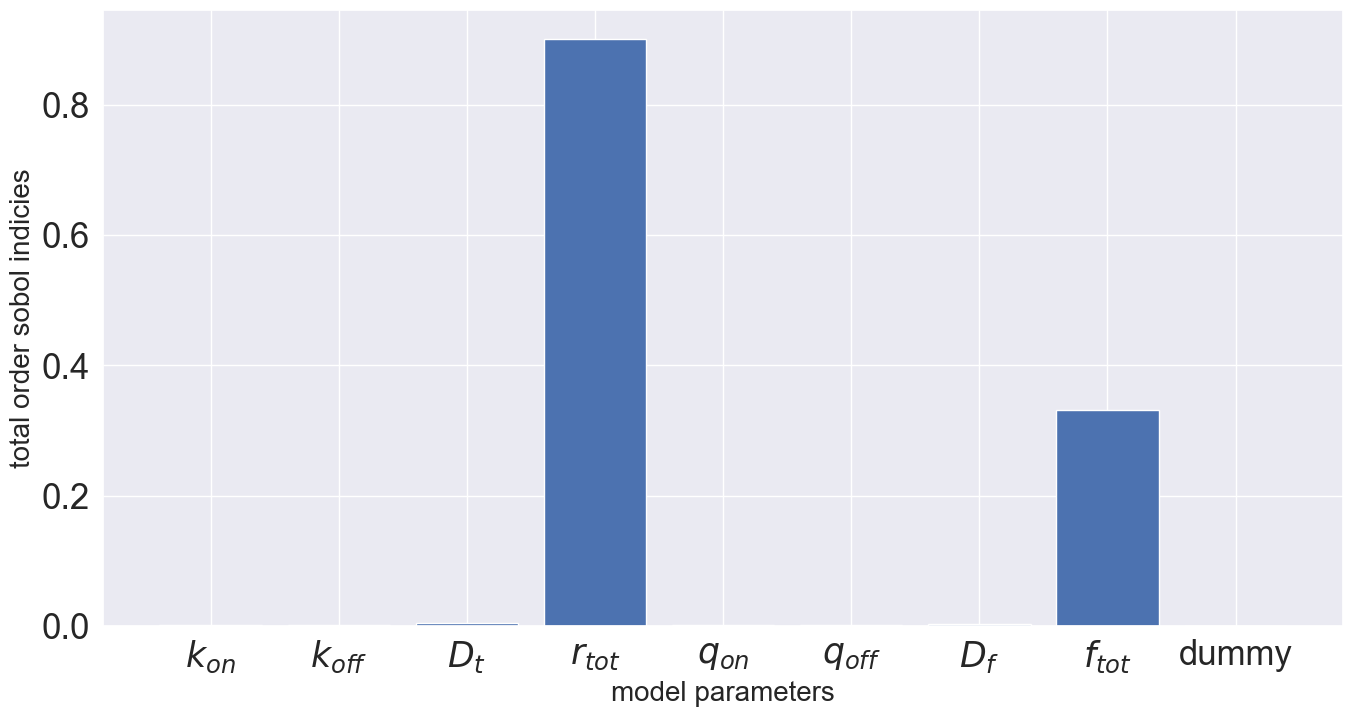

In [ ]:
sns.set_context('talk')
sns.set_theme()
fig, ax = plt.subplots(figsize=(16, 8))
ax.tick_params(labelsize=25)
names= [r'$k_{on}$', r'$k_{off}$', r'$D_t$', r'$r_{tot}$', r'$q_{on}$', r'$q_{off}$', r'$D_f$', r'$f_{tot}$', 'dummy']
ax.bar(names, Si['ST'])
ax.set_xlabel('model parameters', fontsize=20)
ax.set_ylabel('total order sobol indicies', fontsize=20)

In [ ]:
rtots = np.geomspace(1e4, 1e6, 250)
ftots = [1e4, 1e5, 1e6]
A0s = np.geomspace(1e-12, 1e-5, 750)
solution_array = np.zeros((len(ftots), len(rtots)))

kon = 1e5
koff = 1e-2
D_t = 5e-14
qon = 6.5e3
qoff = 4.7e-3
D_f = 7.4e-14

for i, ftot in enumerate(ftots):
    print(i)
    for j, rtot in enumerate(rtots):
        holder = np.zeros_like(A0s)
        for k, Ainit in enumerate(A0s):
             holder[k] = calc_crosslinks(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot)

        solution_array[i, j] = EC50_finder(holder, A0s) 
            

0
1
2


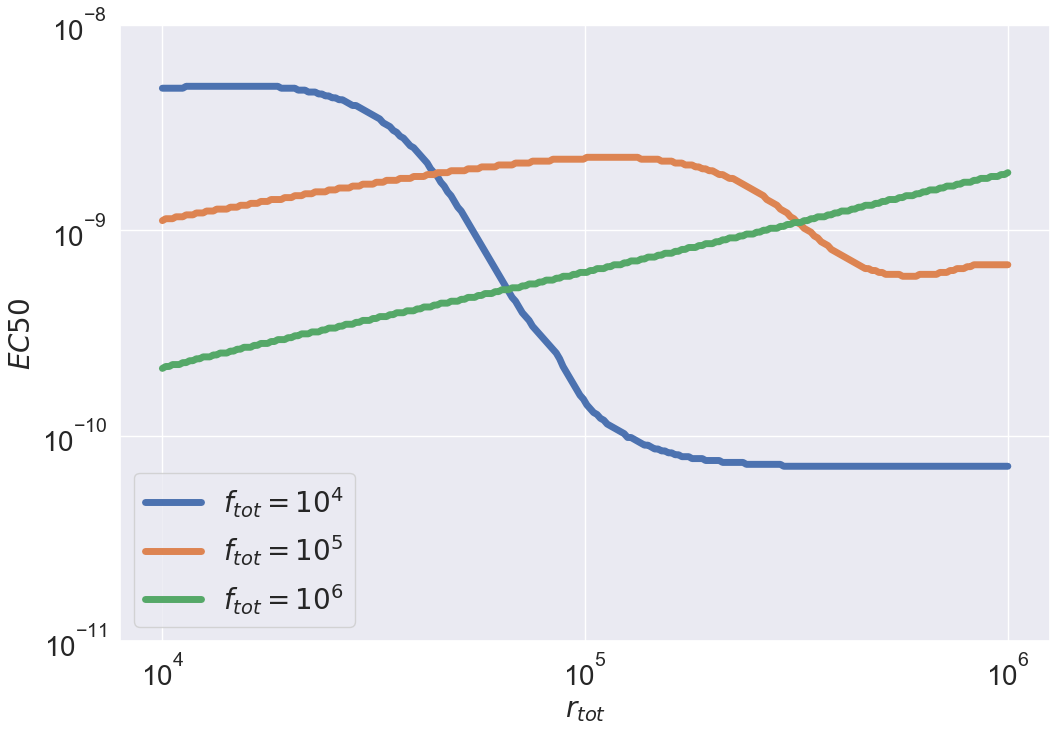

In [ ]:
fig, ax = plt.subplots(figsize = (12, 8))
labels = [r'$10^4$', r'$10^5$', r'$10^6$']
for i in range(len(ftots)):
    label = r'$f_{tot} = $' + labels[i]
    ax.loglog(rtots, solution_array[i, :], label=label, lw=5)

ax.tick_params(labelsize=20)
ax.legend(loc='best', fontsize=20)
ax.set_xlabel(r'$r_{tot}$', fontsize=20)
ax.set_ylabel(r'$EC50$', fontsize=20)
ax.set_ylim(1e-11, 1e-8)
plt.show()